In [1]:
%matplotlib inline
import os
import sys
import json
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier

from spotirecs import get_playlist_tracks, get_features, Playlists

# pandas settings
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
def dict_to_json(data: dict, path: str):
    with open(path, "w", encoding="utf-8") as outfile:
        json.dump(data, outfile)

In [3]:
username_id = '113586775'

playlist_of_interest_name = 'Favorites'

## Initialization

In [4]:
# Logging in

spotify = spotipy.Spotify(requests_timeout=10, client_credentials_manager=SpotifyClientCredentials())

# Which playlists do I have?
playlists: Playlists | None = spotify.user_playlists(username_id)
if playlists is None:
    print("Playlists could not be retrieved")
    sys.exit(1)

playlist_of_interest = None

playlists_of_no_interest = []
for playlist in playlists['items']:
    if playlist['name'] == playlist_of_interest_name:
        playlist_of_interest = playlist
    elif playlist['owner']['id'] == username_id:
        playlists_of_no_interest.append(playlist)


In [5]:
if playlist_of_interest is None:
    print("Given playlist name can not be found")
    sys.exit(1)

good_track_ids, good_track_names = get_playlist_tracks(spotify, playlist_of_interest)

bad_track_ids = []
bad_track_names = []

for playlist in playlists_of_no_interest:
    tmp_ids, tmp_names = get_playlist_tracks(spotify, playlist)
    
    for tmp_id, tmp_name in zip(tmp_ids, tmp_names):
        if tmp_id not in good_track_ids and tmp_id not in bad_track_ids:
            bad_track_ids.append(tmp_id)
            bad_track_names.append(tmp_name)

In [6]:
ratings = [1] * len(good_track_ids) + [0] * len(bad_track_ids)
track_ids = good_track_ids + bad_track_ids
track_names = good_track_names + bad_track_names

## Feature-extraction

In [7]:
if not os.path.isfile('track_features.csv'):
    print("Audio features not found")
    print("\tCalculating ...")
    features = get_features(spotify, track_ids)
    favorites_df = pd.DataFrame(features, index=track_names)
    favorites_df['rating'] = ratings
    favorites_df.to_csv('track_features.csv')
else:
    print("Audio features found")
    read_df = pd.read_csv('track_features.csv', index_col=0)
    read_ids = read_df['id']
    
    print("\tFinding new tracks ...")
    tmp_indices = []
    for i, track_id in enumerate(track_ids):
        if track_id not in read_ids.values:
            tmp_indices.append(i)

    tmp_ids = [track_ids[i] for i in tmp_indices]
    tmp_names = [track_names[i] for i in tmp_indices]
    tmp_ratings = [ratings[i] for i in tmp_indices]
    tmp_features_df = pd.DataFrame(get_features(spotify, tmp_ids), index=tmp_names)
    tmp_features_df['rating'] = tmp_ratings
    
    print("\tUpdating audio features ...")
    tmp_features_df.to_csv('track_features.csv', mode='a')
    
    print("\tCreating audio features dataframe ...")
    read_df = pd.concat([read_df, tmp_features_df])
    favorites_df = read_df[read_df['id'].isin(track_ids)]

print("Done!")
favorites_df

Audio features not found
	Calculating ...
Done!


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,rating
Citizen/Soldier,0.631,0.822,8,-5.503,1,0.0343,0.01140,0.017000,0.1970,0.4830,96.999,audio_features,3NZr9rsioE182Rv8dqZG6g,spotify:track:3NZr9rsioE18...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,232907,4,1
Waterline - 2010 - Remaster,0.386,0.797,0,-7.230,1,0.0372,0.00189,0.000005,0.0959,0.2300,108.836,audio_features,0ayPGGN1YW9lU7v00uOM5E,spotify:track:0ayPGGN1YW9l...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,273160,4,1
Love Is a Loser's Game - 2010 - Remaster,0.307,0.555,10,-7.354,0,0.0255,0.01410,0.000000,0.0865,0.2650,90.640,audio_features,7oyVUb08xXoOqlvtoI1c8Y,spotify:track:7oyVUb08xXoO...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,227933,4,1
Sweet Child O' Mine,0.435,0.947,6,-4.759,1,0.0489,0.08760,0.072700,0.1130,0.6370,125.133,audio_features,32e5Wq10DT7xYrlRl5qSYF,spotify:track:32e5Wq10DT7x...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,355267,4,1
Paradise City,0.277,0.979,11,-5.578,1,0.0979,0.01830,0.013800,0.1170,0.4510,100.339,audio_features,2bHQrsgmBzX5WF7thpMZrV,spotify:track:2bHQrsgmBzX5...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,406200,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.172,0.228,2,-17.281,0,0.0397,0.62200,0.945000,0.0705,0.0339,129.148,audio_features,2V3hP9u4jI9I9ftHrgZ0MF,spotify:track:2V3hP9u4jI9I...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,320467,3,0
Brass Buttons,0.161,0.345,9,-16.228,0,0.0435,0.13100,0.853000,0.1890,0.0603,94.033,audio_features,5kHSrLEGsoOTfazEKvVliP,spotify:track:5kHSrLEGsoOT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,457107,4,0
Out Of The Frying-Pan,0.358,0.536,9,-12.392,1,0.0372,0.18100,0.904000,0.1930,0.1990,89.793,audio_features,608UmlS8Q8Kp3EztDD2SUI,spotify:track:608UmlS8Q8Kp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,353440,4,0
A Good Omen,0.173,0.388,0,-15.277,1,0.0366,0.03810,0.909000,0.1710,0.0491,112.089,audio_features,2wcmpZsg0O4R0xNeUPZ50o,spotify:track:2wcmpZsg0O4R...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,344747,4,0


## Pre-processing

In [8]:
training_df = favorites_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "rating"]]
training_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
Citizen/Soldier,0.01140,0.631,232907,0.822,0.017000,8,0.1970,-5.503,1,0.0343,96.999,0.4830,1
Waterline - 2010 - Remaster,0.00189,0.386,273160,0.797,0.000005,0,0.0959,-7.230,1,0.0372,108.836,0.2300,1
Love Is a Loser's Game - 2010 - Remaster,0.01410,0.307,227933,0.555,0.000000,10,0.0865,-7.354,0,0.0255,90.640,0.2650,1
Sweet Child O' Mine,0.08760,0.435,355267,0.947,0.072700,6,0.1130,-4.759,1,0.0489,125.133,0.6370,1
Paradise City,0.01830,0.277,406200,0.979,0.013800,11,0.1170,-5.578,1,0.0979,100.339,0.4510,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.62200,0.172,320467,0.228,0.945000,2,0.0705,-17.281,0,0.0397,129.148,0.0339,0
Brass Buttons,0.13100,0.161,457107,0.345,0.853000,9,0.1890,-16.228,0,0.0435,94.033,0.0603,0
Out Of The Frying-Pan,0.18100,0.358,353440,0.536,0.904000,9,0.1930,-12.392,1,0.0372,89.793,0.1990,0
A Good Omen,0.03810,0.173,344747,0.388,0.909000,0,0.1710,-15.277,1,0.0366,112.089,0.0491,0


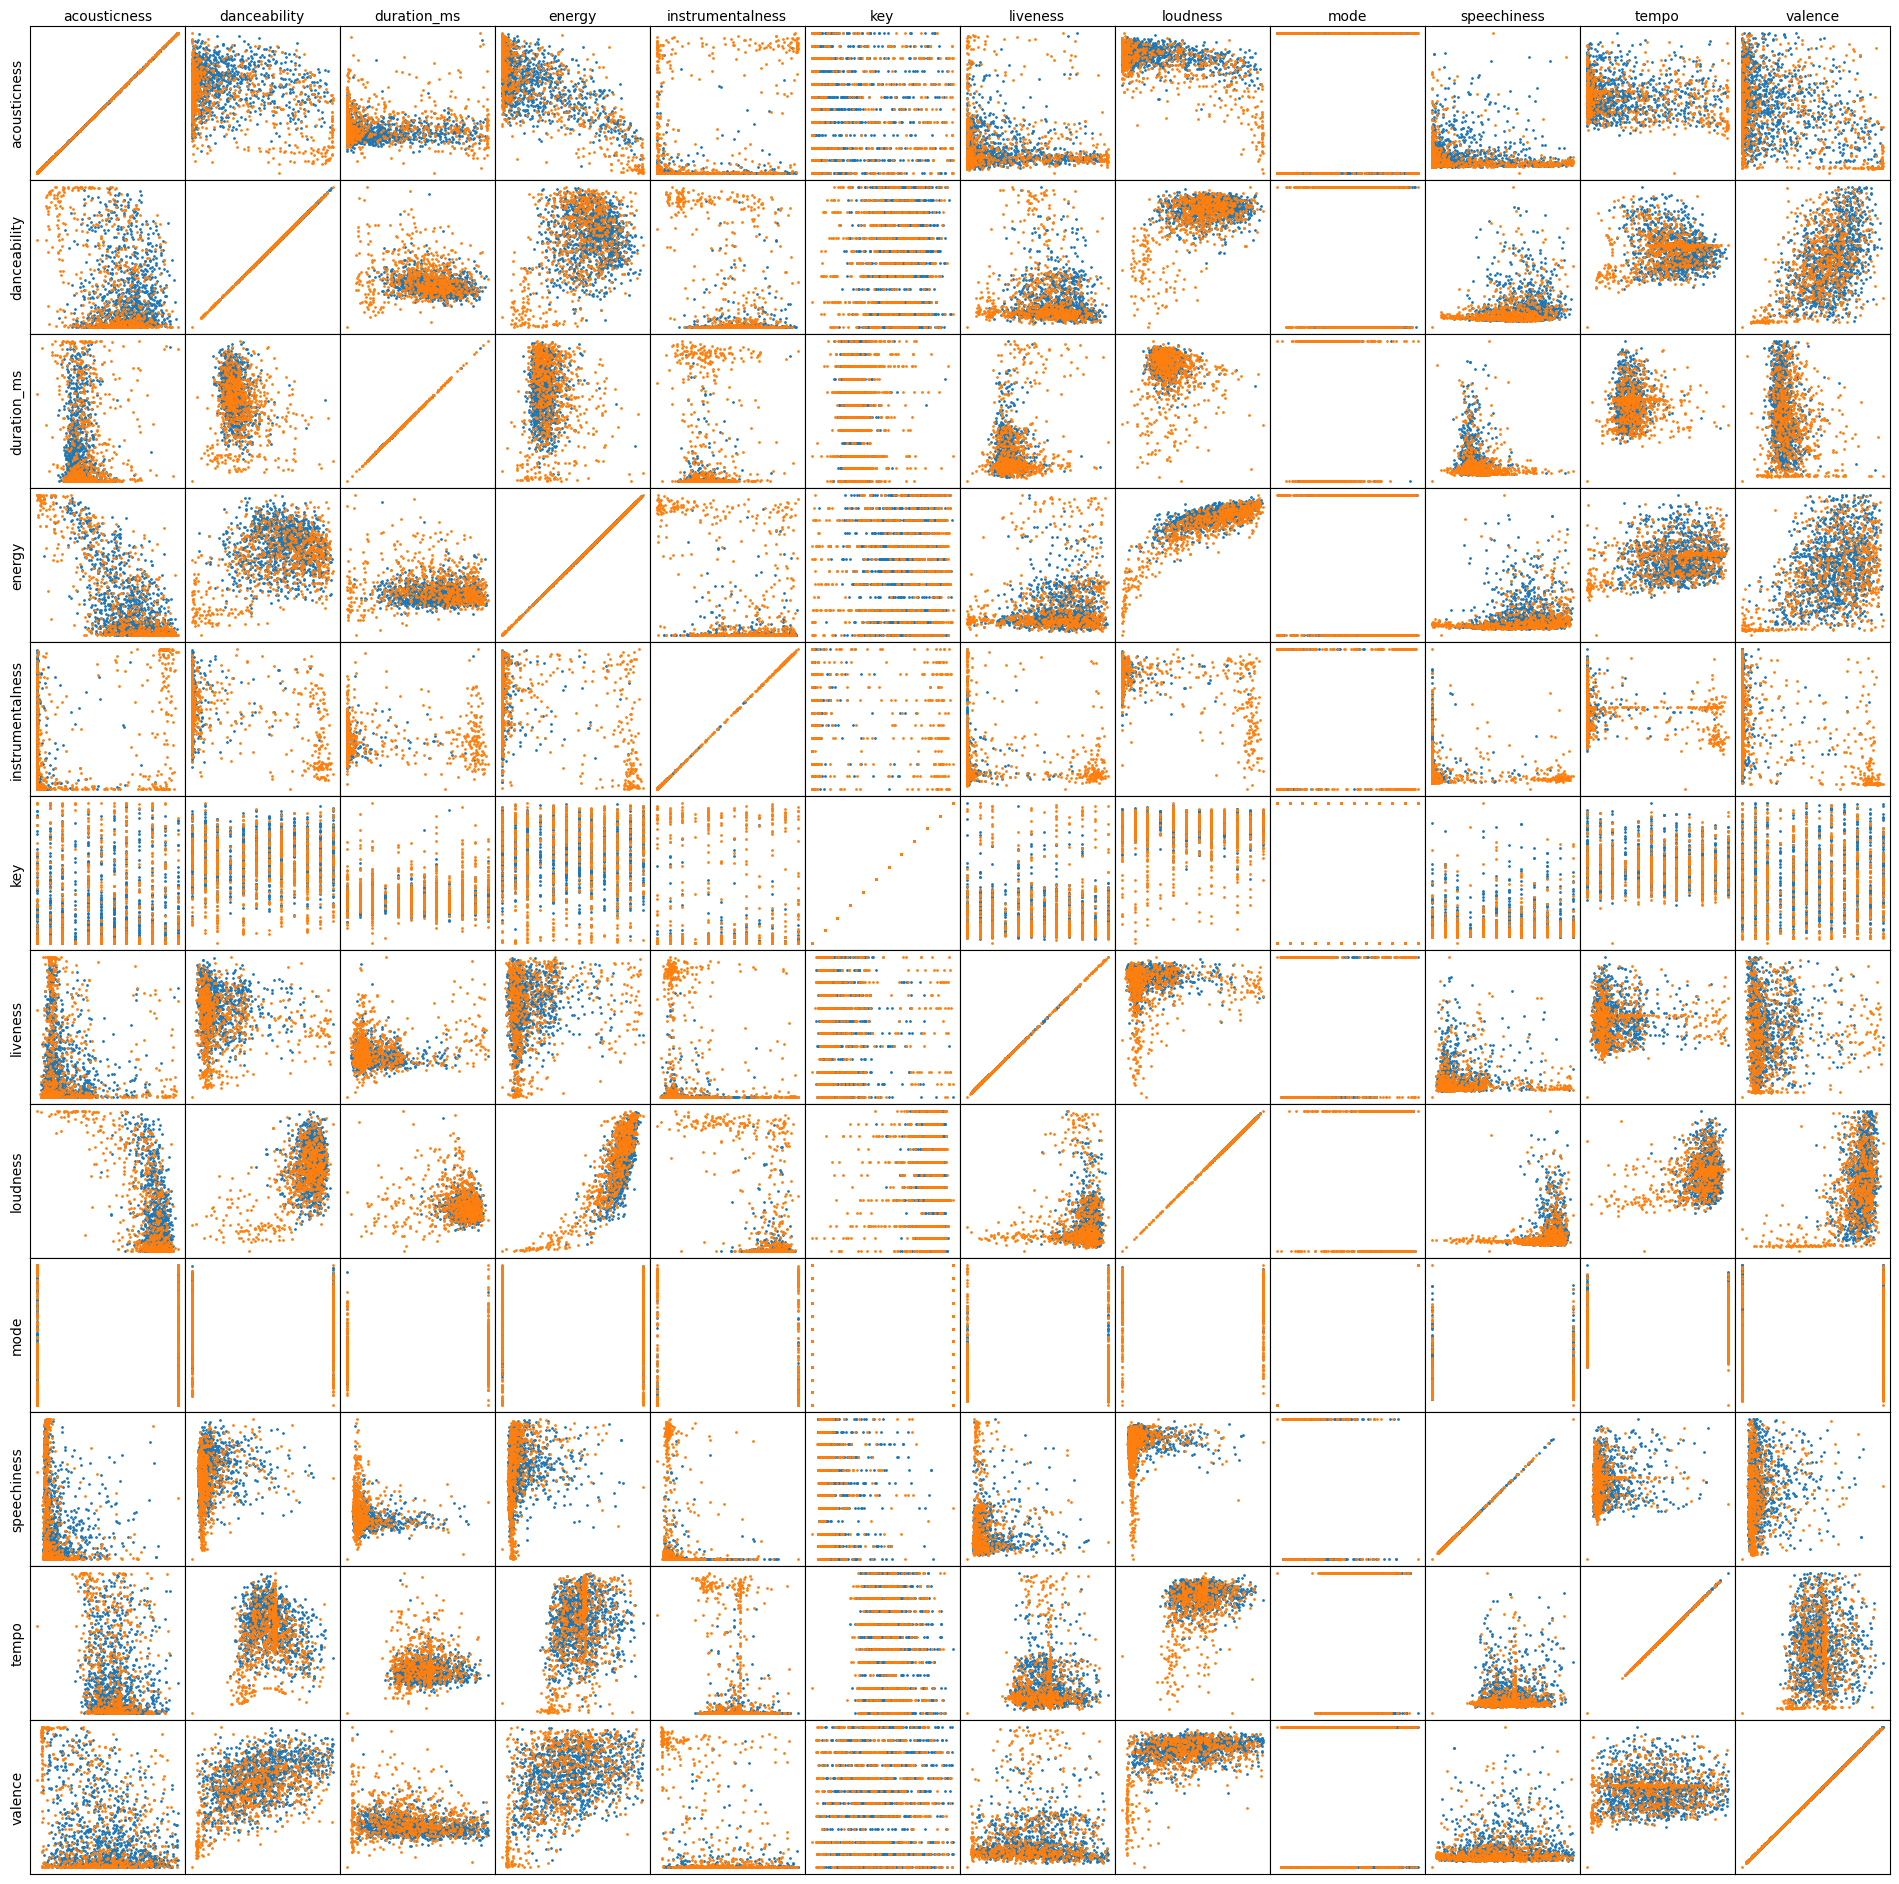

In [9]:
columns = training_df.columns[:-1]

fig, axes = plt.subplots(len(columns), len(columns), figsize=(len(columns) * 2, len(columns) * 2))
for i, col_i in enumerate(columns):
    for j, col_j in enumerate(columns):
        ax = axes[j, i]
        ax.scatter(
            training_df.loc[training_df['rating'] == 1][col_j], 
            training_df.loc[training_df['rating'] == 1][col_i], 
            s=1, c='tab:blue'
        )
        ax.scatter(
            training_df.loc[training_df['rating'] == 0][col_j], 
            training_df.loc[training_df['rating'] == 0][col_i], 
            s=1, c='tab:orange'
        )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(col_j)
        if j == 0:
            ax.set_xlabel(col_i)
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

Number of components for 95% variance: 10


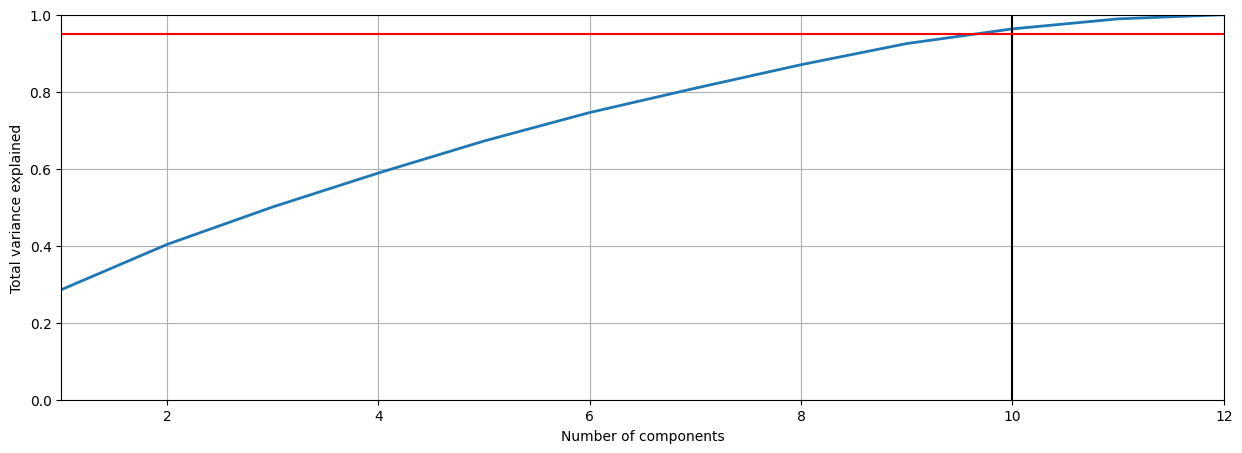

In [10]:
X_train = training_df.drop('rating', axis=1)
y_train = training_df['rating']

X_scaled = StandardScaler().fit_transform(X_train)
pca = decomposition.PCA().fit(X_scaled)

variance_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_ratio)
threshold = 0.95
n_components = next(i for i, v in enumerate(cum_var) if v > threshold) + 1
print(f"Number of components for {threshold*100:.0f}% variance: {n_components}")

plt.figure(figsize=(15,5))
plt.plot(range(1,13), cum_var, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid()
plt.axvline(n_components, c='k')
plt.axhline(threshold, c='r')


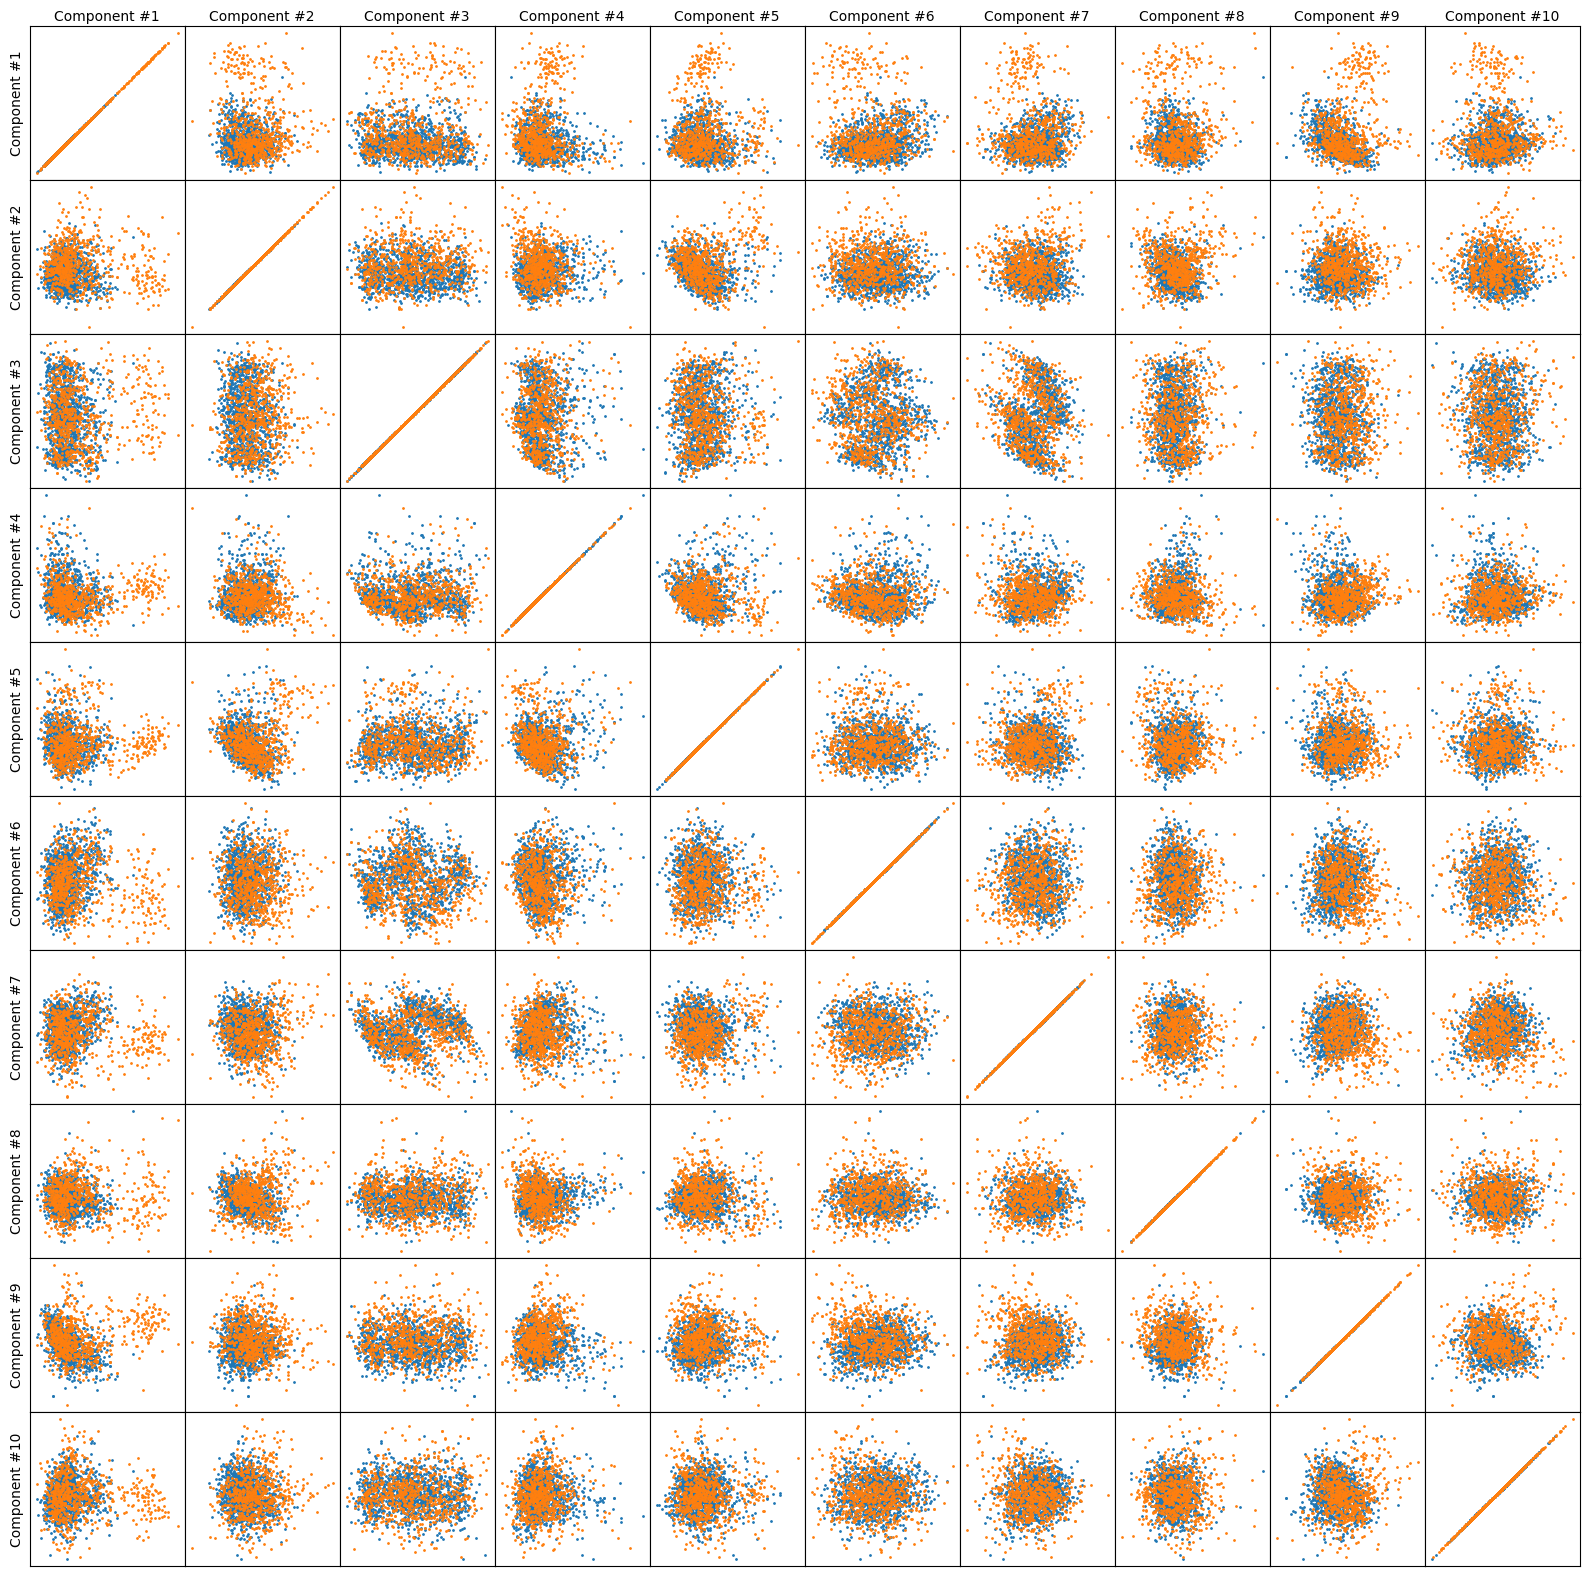

In [11]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(n_components, n_components, figsize=(n_components*2, n_components*2))
for i in range(n_components):
    for j in range(n_components):
        ax = axes[j, i]
        ax.scatter(X_train_pca[y_train == 1][:, i], X_train_pca[y_train == 1][:, j], c='tab:blue', s=1)
        ax.scatter(X_train_pca[y_train == 0][:, i], X_train_pca[y_train == 0][:, j], c='tab:orange', s=1)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if i == 0:
            ax.set_ylabel(f"Component #{j + 1}")
        if j == 0:
            ax.set_xlabel(f"Component #{i + 1}")
            ax.xaxis.set_label_position('top') 
plt.subplots_adjust(wspace=0, hspace=0)

In [12]:
v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
X_names_sparse = v.fit_transform(track_names)
X_names_sparse.shape

X_train = sparse.csr_matrix(sparse.hstack([X_train_pca, X_names_sparse]))
X_train.shape

(1937, 10010)

## Training

In [13]:
# K-nearest neighbor classification
n_splits = 5
max_neighbors = 50

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

knc_params = {'n_neighbors': range(1, max_neighbors + 1)}
knc = KNeighborsClassifier(n_jobs=-1)

knc_grid = GridSearchCV(knc, knc_params, n_jobs=-1, cv=skf, verbose=1)
knc_grid.fit(X_train, y_train)
print("Best score: ", knc_grid.best_score_)

grid_results = pd.DataFrame(knc_grid.cv_results_)
grid_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score:  0.7377380857241802


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005955,0.002130,0.989422,0.201473,1,{'n_neighbors': 1},0.662371,0.698454,0.661499,0.684755,0.656331,0.672682,0.016178,49
1,0.003259,0.001262,0.700264,0.058844,2,{'n_neighbors': 2},0.613402,0.662371,0.633075,0.656331,0.576227,0.628281,0.031314,50
2,0.004492,0.003289,0.774192,0.112535,3,{'n_neighbors': 3},0.677835,0.757732,0.700258,0.697674,0.708010,0.708302,0.026643,47
3,0.004349,0.002164,0.771916,0.103114,4,{'n_neighbors': 4},0.672680,0.729381,0.695090,0.700258,0.669251,0.693332,0.021712,48
4,0.002615,0.000385,0.682173,0.078893,5,{'n_neighbors': 5},0.708763,0.737113,0.744186,0.723514,0.713178,0.725351,0.013563,45
5,0.003534,0.001418,0.698666,0.041307,6,{'n_neighbors': 6},0.698454,0.750000,0.689922,0.705426,0.726098,0.713980,0.021621,46
6,0.002870,0.000575,0.682057,0.042161,7,{'n_neighbors': 7},0.713918,0.750000,0.731266,0.718346,0.726098,0.727926,0.012568,39
7,0.002343,0.000140,0.697167,0.048539,8,{'n_neighbors': 8},0.713918,0.739691,0.726098,0.726098,0.728682,0.726897,0.008205,43
8,0.002744,0.000993,0.702314,0.058431,9,{'n_neighbors': 9},0.716495,0.742268,0.754522,0.723514,0.741602,0.735680,0.013781,6
9,0.003243,0.000724,0.692681,0.048848,10,{'n_neighbors': 10},0.719072,0.757732,0.749354,0.723514,0.739018,0.737738,0.014745,1


(0.0, 50.0)

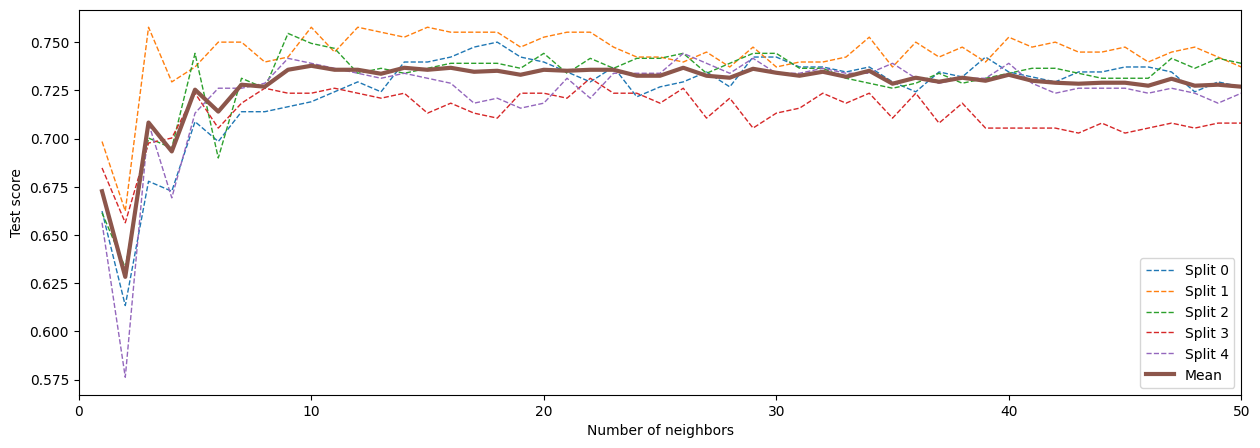

In [14]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results['param_n_neighbors'], grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['param_n_neighbors'], grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Test score')
plt.xlim(0, max_neighbors)

In [15]:
# Random Forest classification

rfc_parameters = {
    'max_features': [4, 6, 8, 10], 
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [3, 5, 7]
}
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
forest_grid = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1)
forest_grid.fit(X_train, y_train)
print("Best score: ", forest_grid.best_score_)

grid_results = pd.DataFrame(forest_grid.cv_results_)
grid_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score:  0.6241602067183463


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.617065,0.034338,0.060334,0.008098,3,4,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
1,0.718318,0.169916,0.067165,0.039094,3,4,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
2,0.766357,0.224421,0.061405,0.019192,3,4,5,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
3,0.628633,0.051638,0.054543,0.006813,3,4,7,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
4,0.672929,0.024955,0.045797,0.006868,3,6,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
5,0.685353,0.131845,0.086473,0.024460,3,6,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
6,0.709072,0.050876,0.083450,0.020521,3,6,5,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
7,0.710956,0.061890,0.108652,0.040305,3,6,7,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
8,0.704194,0.084265,0.066734,0.018700,3,8,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
9,0.611836,0.020609,0.053160,0.006088,3,8,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8


([], [])

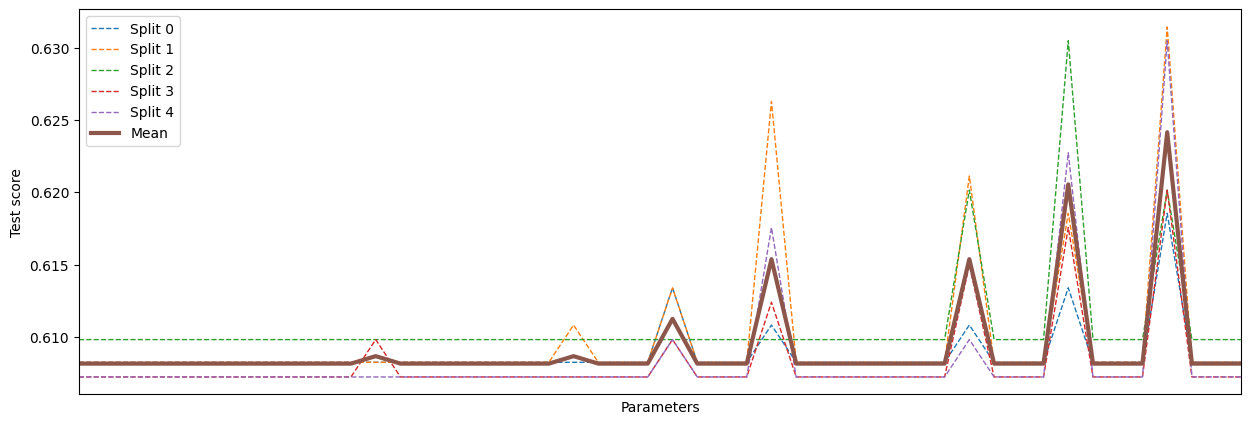

In [16]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

In [17]:
# Decision tree classification

tree_parameters = {
    'max_depth': range(1,11),
    'max_features': range(4, 11)
}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_parameters, cv=skf, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
print("Best score: ", tree_grid.best_score_)

grid_results = pd.DataFrame(tree_grid.cv_results_)
grid_results

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best score:  0.6288273528863316


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004425,0.000358,0.002977,0.001255,1,4,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,68
1,0.005501,0.000915,0.002080,0.000409,1,5,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.609819,0.609819,0.609190,0.000770,65
2,0.004823,0.000461,0.002393,0.000583,1,6,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,68
3,0.005565,0.000372,0.002505,0.000691,1,7,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.617571,0.607235,0.607235,0.609707,0.003958,59
4,0.004921,0.000862,0.002373,0.000330,1,8,"{'max_depth': 1, 'max_feat...",0.634021,0.613402,0.609819,0.607235,0.607235,0.614342,0.010096,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.008731,0.003367,0.002627,0.000622,10,6,"{'max_depth': 10, 'max_fea...",0.618557,0.621134,0.620155,0.620155,0.609819,0.617964,0.004155,11
66,0.007931,0.002928,0.002865,0.000580,10,7,"{'max_depth': 10, 'max_fea...",0.608247,0.618557,0.609819,0.614987,0.627907,0.615903,0.007037,19
67,0.006695,0.001170,0.002977,0.000541,10,8,"{'max_depth': 10, 'max_fea...",0.603093,0.618557,0.617571,0.609819,0.627907,0.615389,0.008411,23
68,0.005997,0.001642,0.003107,0.000901,10,9,"{'max_depth': 10, 'max_fea...",0.608247,0.615979,0.622739,0.609819,0.638243,0.619006,0.010893,7


([], [])

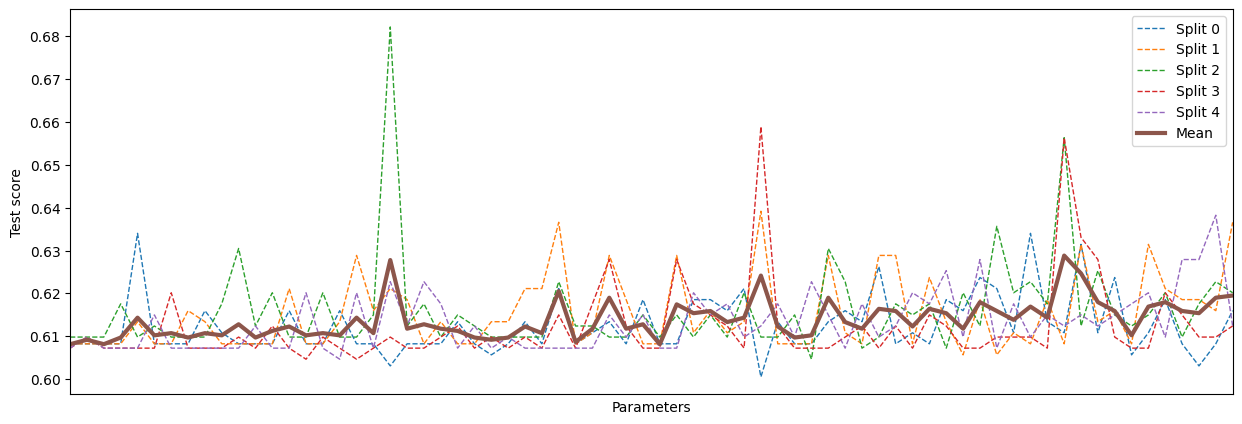

In [18]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

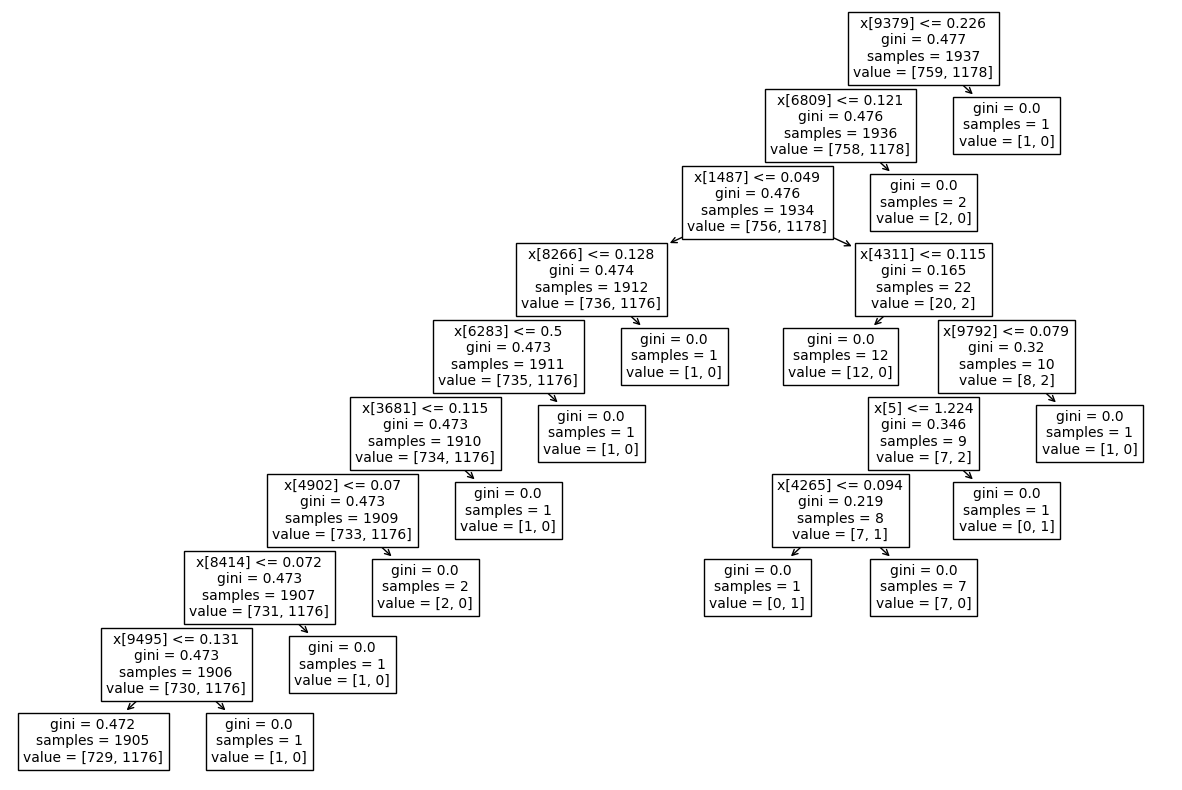

In [19]:
plt.figure(figsize=(15, 10))
plot_tree(tree_grid.best_estimator_, fontsize=10)
print()

## Testing

In [20]:
rec_tracks_per_track = 2
max_rec_tracks = 2000
rec_tracks_per_track = min([max_rec_tracks, len(favorites_df['id']) * rec_tracks_per_track]) // len(favorites_df['id'])
print(f"Using {rec_tracks_per_track} test tracks per track")

rec_tracks = []
for i in favorites_df['id']:
    try:
        rec_tracks.extend(spotify.recommendations(seed_tracks=[i], limit=rec_tracks_per_track)['tracks'])
    except:
        break

Using 1 test tracks per track


In [21]:
rec_track_ids = []
rec_track_names = []
for i in rec_tracks:
    rec_track_ids.append(i['id'])
    rec_track_names.append(i['name'])

rec_features = get_features(spotify, rec_track_ids)
        
rec_playlist_df = pd.DataFrame(rec_features, index=rec_track_names)
rec_playlist_df.drop_duplicates(subset='id', inplace=True)
rec_track_names = rec_playlist_df.index.tolist()
rec_playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Do What You Do,0.4980,0.97400,8,-2.649,1,0.1440,0.002030,0.000000,0.1670,0.6460,165.043,audio_features,4Icu8prpEka7ufeeyVlj7a,spotify:track:4Icu8prpEka7...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,216027,4
Amelia - Part 1: Nothing They Do They Do For You,0.3770,0.36300,2,-12.052,0,0.0313,0.012700,0.001220,0.2830,0.1960,91.572,audio_features,2uwiTK504KCGp4NYD6HLFX,spotify:track:2uwiTK504KCG...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,251827,1
Elia Rising,0.3390,0.70000,11,-6.106,0,0.0338,0.006870,0.000000,0.0967,0.2080,137.935,audio_features,6RYRpQZrnK23GkhrxE6k2u,spotify:track:6RYRpQZrnK23...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,265227,3
Why Do You Think They Call It Dope?,0.4460,0.89400,1,-7.252,1,0.0446,0.001560,0.000007,0.3070,0.3280,133.477,audio_features,0amK9m9xOLBzbuf02JCsWC,spotify:track:0amK9m9xOLBz...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,235293,4
Stick It Out,0.5740,0.94200,0,-5.232,1,0.0413,0.000374,0.000003,0.1410,0.3100,119.988,audio_features,4k9yATQjHBsdUKlt8LpuCv,spotify:track:4k9yATQjHBsd...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,270600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
What Could Go Wrong,0.1880,0.00982,8,-40.523,1,0.0358,0.616000,0.873000,0.0807,0.0490,84.913,audio_features,2SA1tZodYEGiQiOPQqSKaT,spotify:track:2SA1tZodYEGi...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,83293,4
You Can Never Go Back,0.0809,0.00324,2,-37.004,0,0.0452,0.987000,0.947000,0.0629,0.0379,172.172,audio_features,6VpmPE7iKbqC0EvTykGW5t,spotify:track:6VpmPE7iKbqC...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,114467,5
Blissful Rondeau,0.4470,0.33700,7,-22.773,0,0.0355,0.960000,0.737000,0.1120,0.7240,94.977,audio_features,71HjgdihDI9Kg59Fs111af,spotify:track:71HjgdihDI9K...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,73613,3
Perseid Prelude,0.0619,0.07370,5,-17.362,1,0.0374,0.922000,0.853000,0.1370,0.1690,66.116,audio_features,1x8qLAw45jKQCioTyaXEEL,spotify:track:1x8qLAw45jKQ...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,83592,4


In [22]:
testing_df = rec_playlist_df[
    [
        "acousticness", "danceability", "duration_ms", "energy", 
        "instrumentalness",  "key", "liveness", "loudness", "mode", 
        "speechiness", "tempo", "valence"
    ]
]
testing_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Do What You Do,0.002030,0.4980,216027,0.97400,0.000000,8,0.1670,-2.649,1,0.1440,165.043,0.6460
Amelia - Part 1: Nothing They Do They Do For You,0.012700,0.3770,251827,0.36300,0.001220,2,0.2830,-12.052,0,0.0313,91.572,0.1960
Elia Rising,0.006870,0.3390,265227,0.70000,0.000000,11,0.0967,-6.106,0,0.0338,137.935,0.2080
Why Do You Think They Call It Dope?,0.001560,0.4460,235293,0.89400,0.000007,1,0.3070,-7.252,1,0.0446,133.477,0.3280
Stick It Out,0.000374,0.5740,270600,0.94200,0.000003,0,0.1410,-5.232,1,0.0413,119.988,0.3100
...,...,...,...,...,...,...,...,...,...,...,...,...
What Could Go Wrong,0.616000,0.1880,83293,0.00982,0.873000,8,0.0807,-40.523,1,0.0358,84.913,0.0490
You Can Never Go Back,0.987000,0.0809,114467,0.00324,0.947000,2,0.0629,-37.004,0,0.0452,172.172,0.0379
Blissful Rondeau,0.960000,0.4470,73613,0.33700,0.737000,7,0.1120,-22.773,0,0.0355,94.977,0.7240
Perseid Prelude,0.922000,0.0619,83592,0.07370,0.853000,5,0.1370,-17.362,1,0.0374,66.116,0.1690


In [23]:
estimators = [knc_grid, forest_grid, tree_grid]

testing_df_scaled = StandardScaler().fit_transform(testing_df)

X_test = pca.transform(testing_df_scaled)
X_test_names = v.transform(rec_track_names)

X_test = sparse.csr_matrix(sparse.hstack([X_test, X_test_names]))
y_pred_final = np.array([1] * X_test_names.shape[0])

for estimator in estimators:
    estimator.best_estimator_.fit(X_train, y_train)
    y_pred = estimator.best_estimator_.predict(X_test)
    
    y_pred_final = y_pred_final * y_pred
    print("Number of disliked tracks by model: ", sum(y_pred == 0))
    print("Number of disliked tracks: ", sum(y_pred_final == 0))
    print("Number of liked tracks: ", sum(y_pred_final == 1))
    print()

Number of disliked tracks by model:  598
Number of disliked tracks:  598
Number of liked tracks:  1266

Number of disliked tracks by model:  1
Number of disliked tracks:  598
Number of liked tracks:  1266

Number of disliked tracks by model:  24
Number of disliked tracks:  608
Number of liked tracks:  1256



In [24]:
final_tracks = testing_df[y_pred_final.astype(bool)]
final_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Do What You Do,0.002030,0.4980,216027,0.974,0.000000,8,0.1670,-2.649,1,0.1440,165.043,0.6460
Amelia - Part 1: Nothing They Do They Do For You,0.012700,0.3770,251827,0.363,0.001220,2,0.2830,-12.052,0,0.0313,91.572,0.1960
Elia Rising,0.006870,0.3390,265227,0.700,0.000000,11,0.0967,-6.106,0,0.0338,137.935,0.2080
Why Do You Think They Call It Dope?,0.001560,0.4460,235293,0.894,0.000007,1,0.3070,-7.252,1,0.0446,133.477,0.3280
Stick It Out,0.000374,0.5740,270600,0.942,0.000003,0,0.1410,-5.232,1,0.0413,119.988,0.3100
...,...,...,...,...,...,...,...,...,...,...,...,...
My Mood - Instrumental,0.786000,0.3890,194000,0.361,0.018900,0,0.0987,-10.637,1,0.0330,143.492,0.2410
Abracadabra,0.797000,0.2860,177947,0.320,0.015500,2,0.1120,-12.157,1,0.0297,99.664,0.0899
C'est la consigne - Bo Le Petit Prince,0.373000,0.3290,94067,0.360,0.022400,5,0.2880,-12.451,1,0.0314,132.644,0.3650
"Concerto for 4 Harpsichords, Strings, and Continuo in A minor, BWV 1065: 1. (Allegro)",0.647000,0.4860,229307,0.291,0.041700,9,0.1010,-20.151,0,0.0304,110.731,0.7610
